1. Dataset Overview

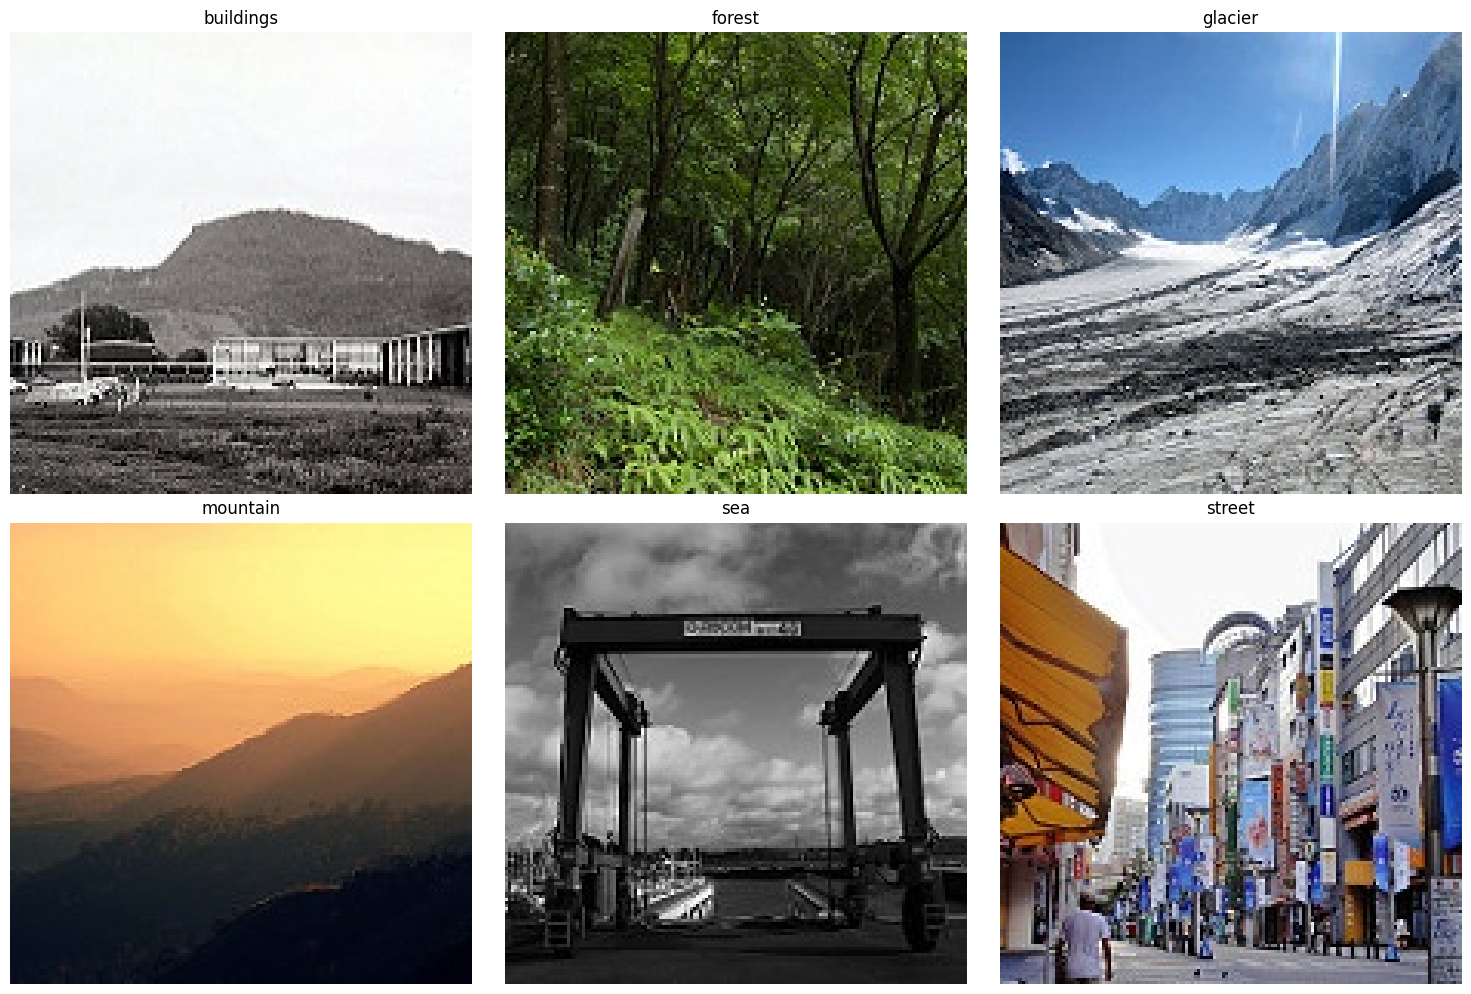

In [1]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the folder paths
train_dir = './seg_train'
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Display a few samples from each category
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, category in enumerate(categories):
    category_path = os.path.join(train_dir, category)
    img_name = os.listdir(category_path)[0]  # Take the first image from each category
    img = load_img(os.path.join(category_path, img_name), target_size=(150, 150))
    axes[i//3, i%3].imshow(img)
    axes[i//3, i%3].set_title(category)
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.show()


2. Model Architecture

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_cnn_model():
    model = models.Sequential()

    # First Convolutional Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    
    # Second Convolutional Layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # Third Convolutional Layer
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    # Flatten the output and add Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout for regularization
    model.add(layers.Dense(6, activation='softmax'))  # Output layer for 6 categories

    return model

model = create_cnn_model()
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 74, 74, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                      

3. Model Training

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True, 
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training and validation data
train_generator = train_datagen.flow_from_directory(
    './seg_train', 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    './seg_test', 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='categorical'
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Epoch 1/20


438/438 [==============================] - 569s 1s/step - loss: 3.6580 - accuracy: 0.4124 - val_loss: 1.4408 - val_accuracy: 0.4822
Epoch 2/20
438/438 [==============================] - 381s 868ms/step - loss: 1.3358 - accuracy: 0.4889 - val_loss: 1.2289 - val_accuracy: 0.6277
Epoch 3/20
438/438 [==============================] - 332s 759ms/step - loss: 1.1799 - accuracy: 0.5394 - val_loss: 0.8405 - val_accuracy: 0.7144
Epoch 4/20
438/438 [==============================] - 105s 240ms/step - loss: 1.1375 - accuracy: 0.5608 - val_loss: 0.8114 - val_accuracy: 0.7285
Epoch 5/20
438/438 [==============================] - 105s 240ms/step - loss: 1.0453 - accuracy: 0.6030 - val_loss: 0.7938 - val_accuracy: 0.7201
Epoch 6/20
438/438 [==============================] - 107s 244ms/step - loss: 1.0326 - accuracy: 0.6151 - val_loss: 0.7161 - val_accuracy: 0.7537
Epoch 7/20
438/438 [====================

4. Evaluation

94/94 [==============================] - 6s 60ms/step - loss: 0.5937 - accuracy: 0.8117
Test accuracy: 0.81


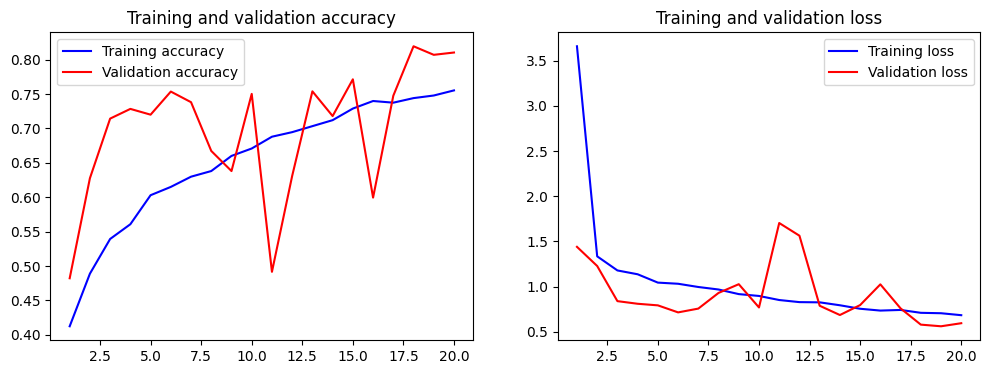

94/94 [==============================] - 5s 53ms/step


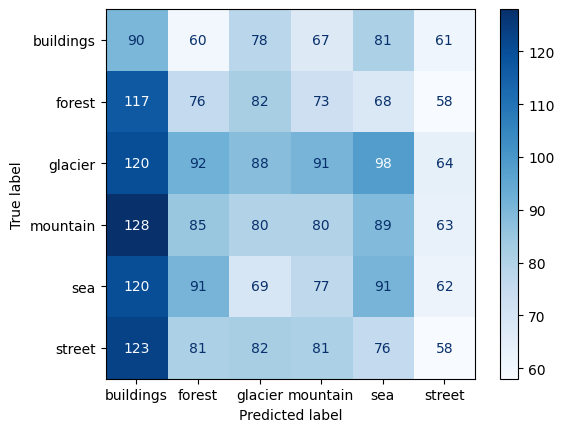

In [4]:
# Evaluate the model
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc:.2f}')

# Plot training and validation accuracy/loss
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_accuracy_loss(history)

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.show()
